In [1]:
import warnings
from rdkit import RDLogger

# 屏蔽 RDKit 警告
RDLogger.DisableLog('rdApp.*')

# 或屏蔽所有 Python 警告
warnings.filterwarnings("ignore")
# 屏蔽 LightGBM 警告
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import optuna
from rdkit.Chem import Descriptors, AllChem

# 数据预处理
df = pd.read_csv('../imputed_selected_features_Toxcity.csv')
labels = df['Toxicity'].values
smiles_list = df['SMILES'].tolist()

y = labels
X = np.load('./Toxicity_smiles_embeddings.npy')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42, stratify=labels
)

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# 定义函数进行单次模型训练和评估
def train_evaluate_xgboost(X_train, y_train, X_test, y_test):
    model = XGBClassifier(
        n_estimators=11, max_depth=4, learning_rate=0.0822040603519007, random_state=42, eval_metric='logloss'
    )
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)
    return auc_score

# 原始标签的模型性能
original_auc = train_evaluate_xgboost(X_train, y_train, X_test, y_test)
print(f"Original AUC: {original_auc:.4f}")

# y-随机化
n_iterations = 2000  # y-随机化迭代次数
randomized_aucs = []

for i in range(n_iterations):
    np.random.shuffle(y_train)  # 打乱训练标签
    auc_score = train_evaluate_xgboost(X_train, y_train, X_test, y_test)
    randomized_aucs.append(auc_score)

# 计算随机化结果的统计信息
randomized_mean_auc = np.mean(randomized_aucs)
randomized_std_auc = np.std(randomized_aucs)
print(f"Randomized AUC (mean): {randomized_mean_auc:.4f}")
print(f"Randomized AUC (std): {randomized_std_auc:.4f}")



Original AUC: 0.9986
Randomized AUC (mean): 0.5149
Randomized AUC (std): 0.1613


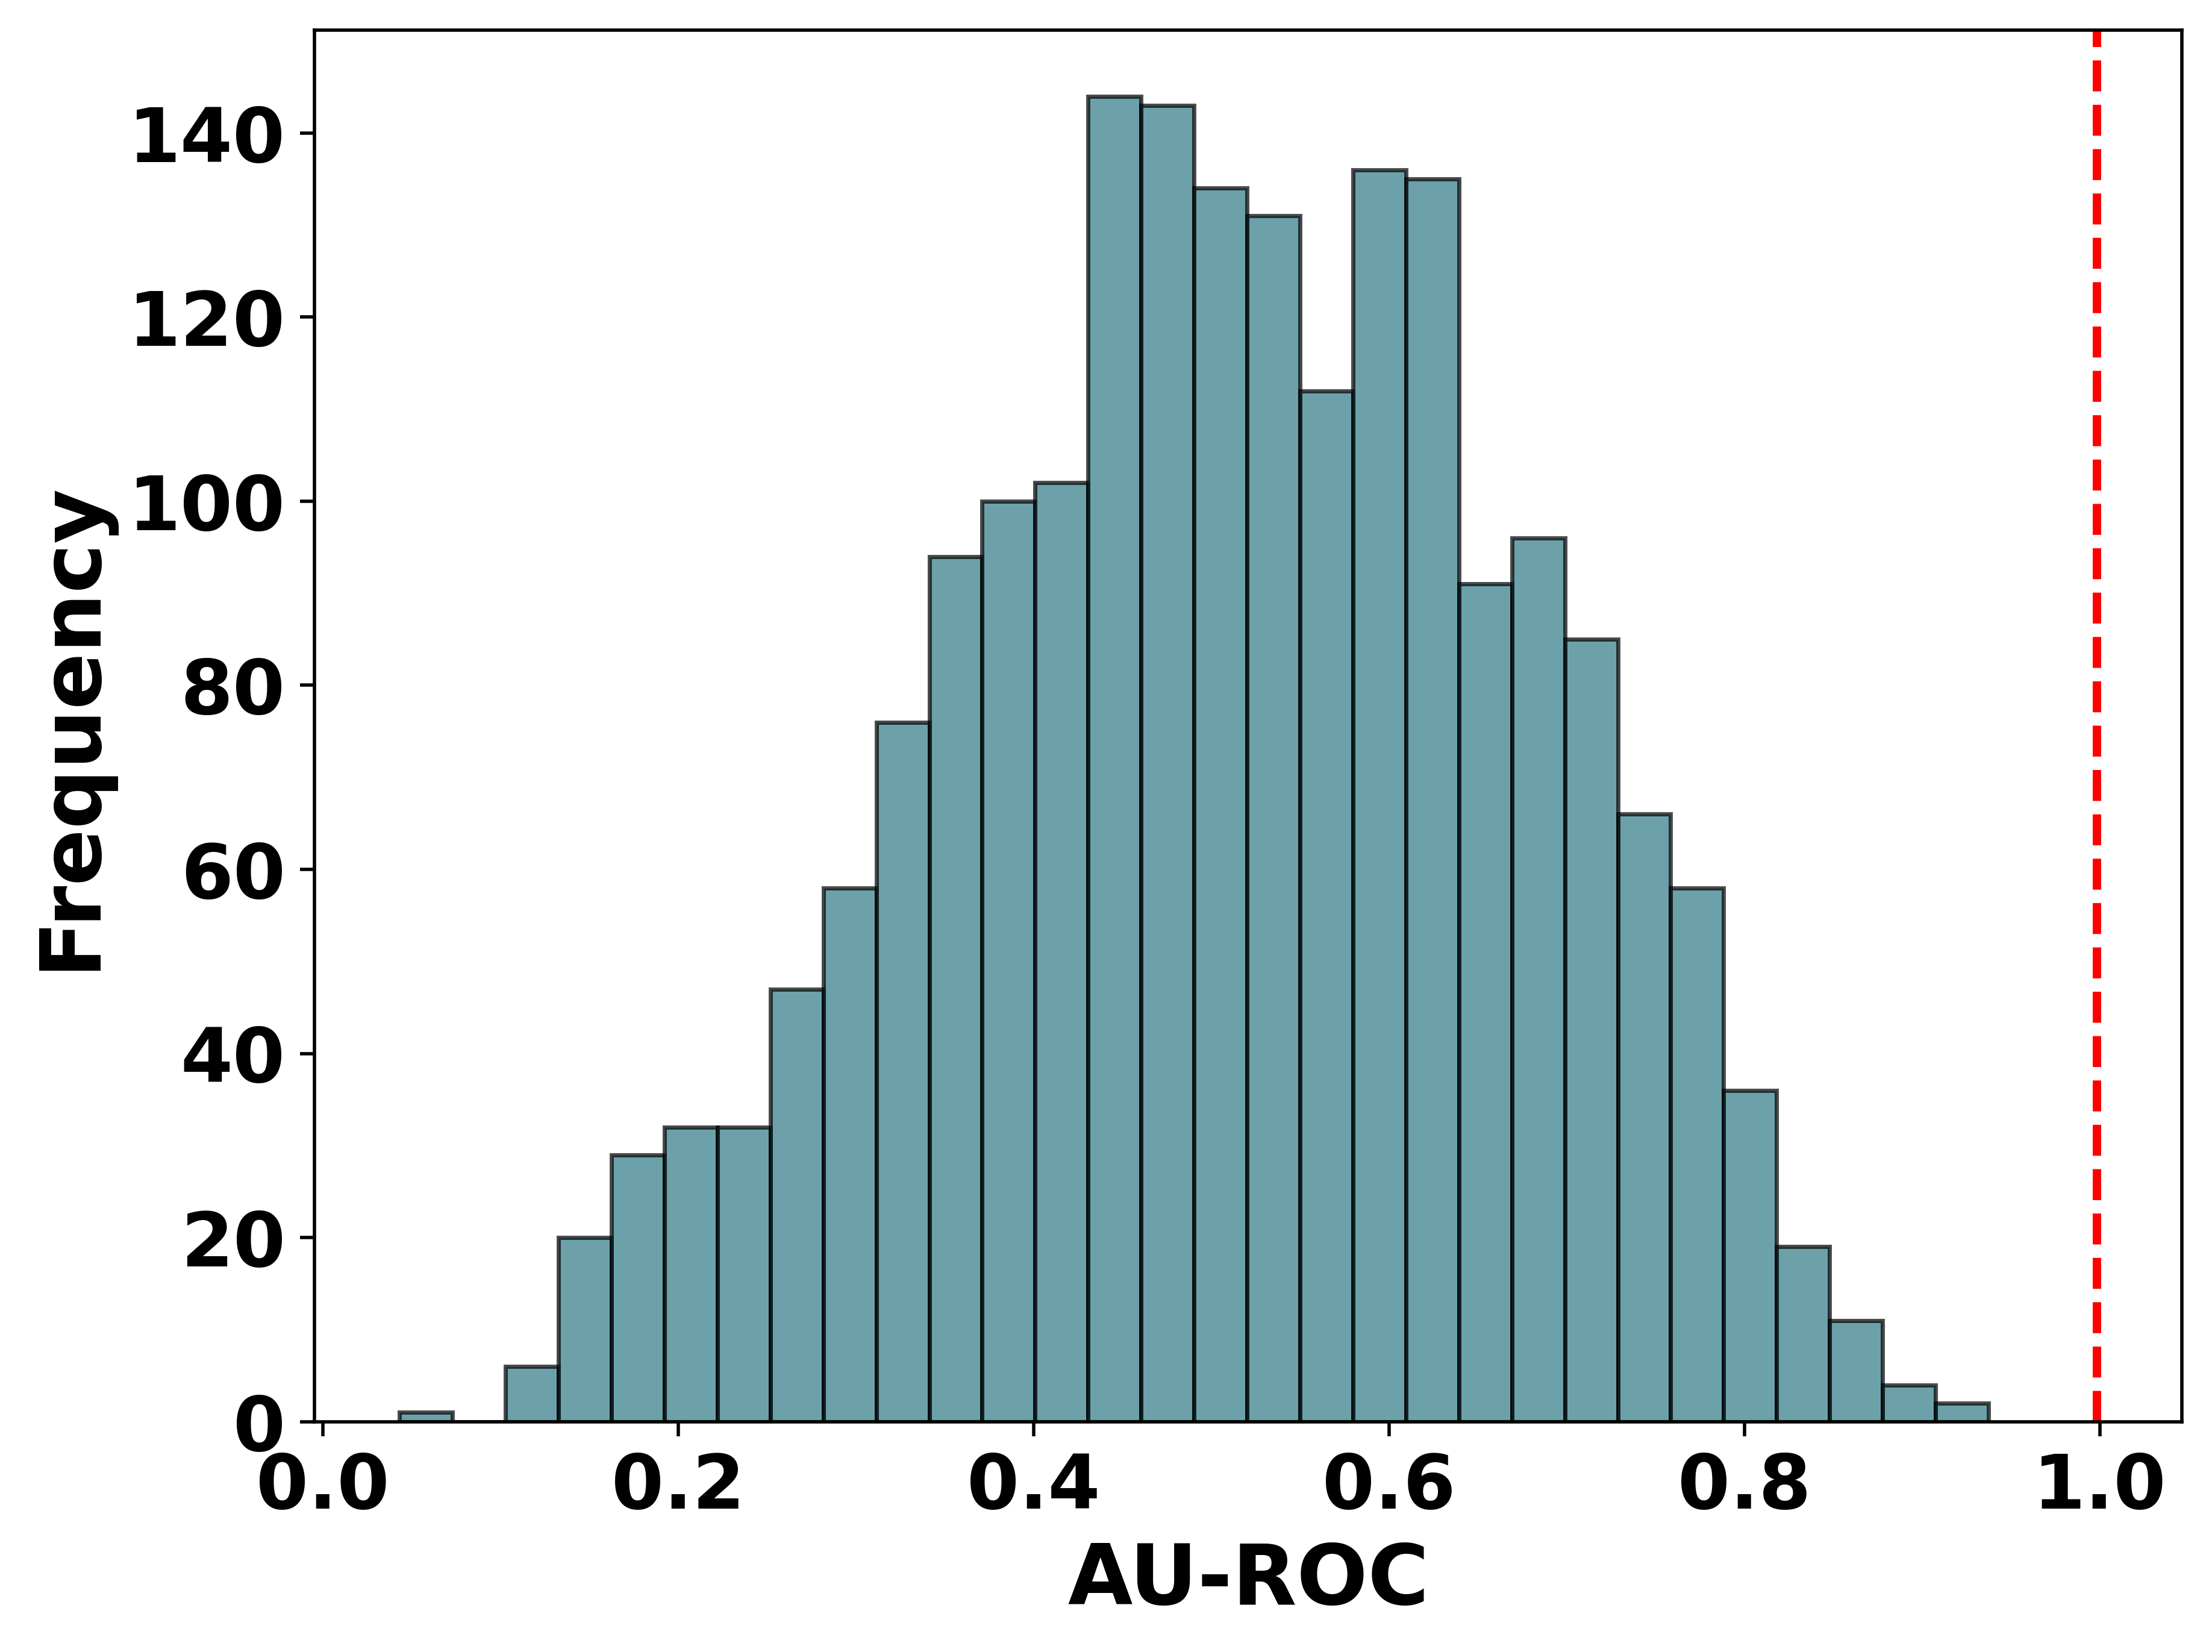

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6), dpi=500)  # 设置更高的dpi，确保高质量图像

# 绘制直方图
plt.hist(randomized_aucs, bins=30, color='#2F7987', alpha=0.7, edgecolor='black')

# 绘制原始AUC的虚线
plt.axvline(original_auc, color='red', linestyle='dashed', linewidth=2)

# 设置标题，并加粗字体
#plt.title("Distribution of AUC Scores from Y-Randomization", fontsize=22, fontweight='bold')

# 设置 X 轴和 Y 轴标签，并加粗字体
plt.xlabel("AU-ROC", fontsize=20, fontweight='bold')
plt.ylabel("Frequency", fontsize=20, fontweight='bold')

# 设置刻度字体大小和加粗
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

# 显示图像
plt.show()

In [6]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import optuna
from rdkit.Chem import Descriptors, AllChem

# 数据预处理
# 数据预处理
df = pd.read_csv('../imputed_selected_features_Toxcity.csv')
labels = df['Toxicity'].values
smiles_list = df['SMILES'].tolist()



y = labels
X = np.load('./Toxicity_smiles_embeddings.npy')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42, stratify=labels
)

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# 模型训练和评估函数
def train_and_evaluate(X_train, y_train, X_test, y_test):
    model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',n_estimators=11, max_depth=4, learning_rate=0.0822040603519007)
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    return pr_auc

# 原始模型性能
original_pr_auc = train_and_evaluate(X_train, y_train, X_test, y_test)
print(f"Original Model PR-AUC: {original_pr_auc:.4f}")

# y-随机化
n_iterations = 2000
randomized_pr_aucs = []

for i in range(n_iterations):
    np.random.seed(i)
    y_train_randomized = np.random.permutation(y_train)  # 打乱训练集标签
    pr_auc = train_and_evaluate(X_train, y_train_randomized, X_test, y_test)
    randomized_pr_aucs.append(pr_auc)

# 统计随机化结果
randomized_mean = np.mean(randomized_pr_aucs)
randomized_std = np.std(randomized_pr_aucs)

print(f"Randomized PR-AUC Mean: {randomized_mean:.4f}")
print(f"Randomized PR-AUC Std: {randomized_std:.4f}")



Original Model PR-AUC: 0.9998
Randomized PR-AUC Mean: 0.8876
Randomized PR-AUC Std: 0.0559


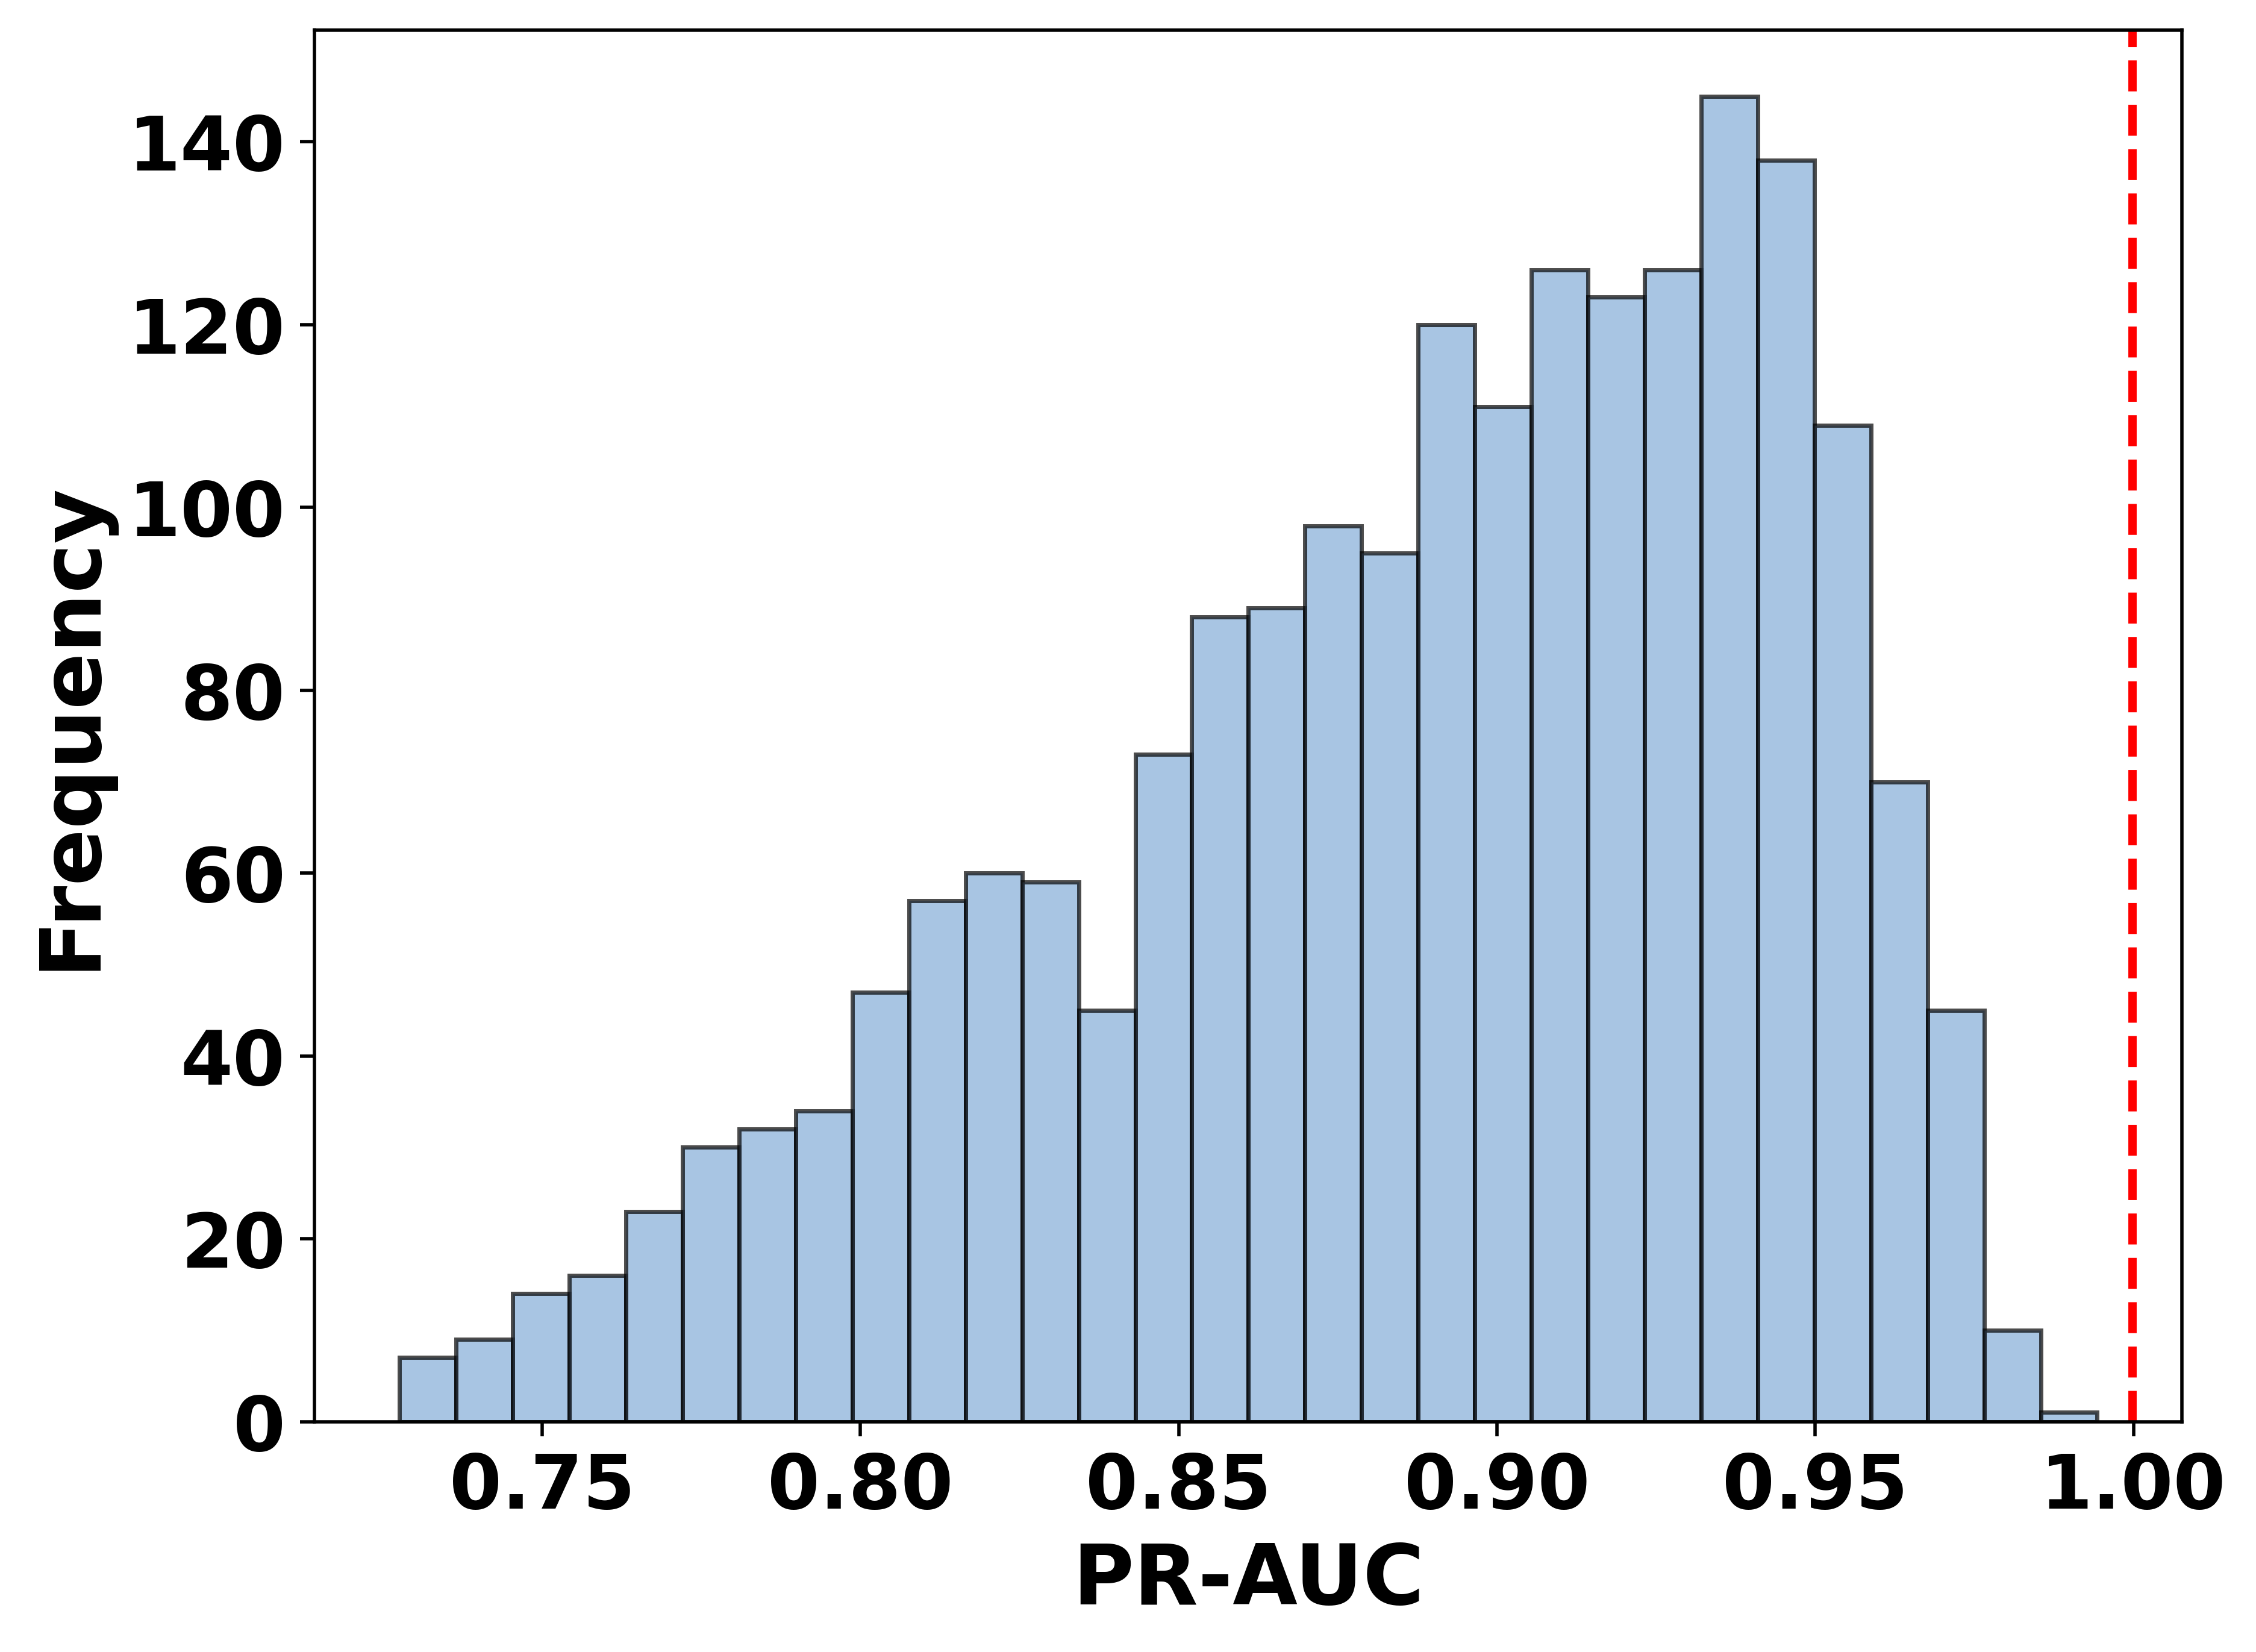

In [8]:
# 绘制AUC分布直方图

plt.figure(figsize=(8, 6), dpi=500)  # 设置更高的dpi，300 dpi一般会产生高质量的图像

plt.hist(randomized_pr_aucs, bins=30, color='#83ADD8', alpha=0.7, edgecolor='black')
plt.axvline(original_pr_auc, color='red', linestyle='dashed', linewidth=2)




#plt.title("Distribution of AUC Scores from Y-Randomization",fontproperties=prop)
plt.xlabel("PR-AUC",fontsize=20, fontweight='bold')
plt.ylabel("Frequency",fontsize=20, fontweight='bold')
# 设置刻度字体大小和加粗
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

#plt.legend()
plt.show()